Распаковка архива с тестовыми данными

In [ ]:
!unzip test.zip -d ./

Устанавливаем зависимости для предобработки текста

In [ ]:
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
condition_met = False

Создаем папку для обработанного текста

In [4]:
os.makedirs('test/test_stt_re', mode=0o777, exist_ok=True)

Удаляем мат если он есть, убираем таймкоды и стоп-слова

In [5]:
regular = r'\b\w*(гей|дроч|разъеб|хуй|сук)\w*\b'

def del_timestamps(text):
    global condition_met
    if text[11] == '6' and not condition_met:
        text = text + ' !'
        condition_met = True
    text = text.split("]  ")[1:]
    return " ".join(text)

with open("test/stop-words-russian.txt", 'r') as f:
    extra_stop_words = f.readlines()
    extra_stop_words = [line.strip() for line in extra_stop_words]

for i in range(100):
    with open(f"test/test_stt/{i}.txt", "r", encoding="utf-8") as f:
        stopwords_ru = stopwords.words('russian')
        lines = f.readlines()
        lines = [del_timestamps(line.strip()) for line in lines]
        lines = " ".join(lines)
        lines = word_tokenize(lines)
        lines = [word for word in lines if not (word in stopwords_ru)]
        lines = " ".join(lines)
        lines = re.sub(regular, '', lines, flags=re.IGNORECASE)
        with open(f"test/test_stt_re/{i}_re.txt", "w", encoding="utf-8") as r:
            r.write(lines)


Устанавливаем зависимости для использования моделей


In [ ]:
!pip install transformers sentencepiece
!pip install torch
!pip install transformers
!pip install einops

Импортируем их

In [8]:
import transformers
import torch
import csv
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import MBartTokenizer, MBartForConditionalGeneration, pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline

Скачиваем модель с сайта HuggingFace для выделения основого текста, ее метрики-
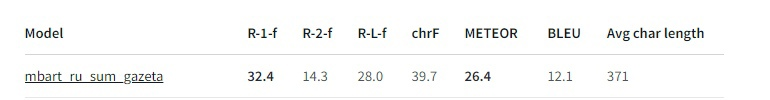

In [ ]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
modelSummary = MBartForConditionalGeneration.from_pretrained(model_name)

Прогоняем модель на тестовых данных пропуская девятую запись так как там нет текста

In [ ]:
for i in range(100):
      if i == 9:
        with open('test_out.txt','a',encoding='utf-8') as w:
              output = '9'
              w.write(output + '\n')
      else:
        with open(f"test/test_stt_re/{i}_re.txt", "r", encoding="utf-8") as f:
            x = f.read()
            article_text = x
            input_ids = tokenizer(
                [article_text],
                max_length=600,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )["input_ids"]
            output_ids = modelSummary.generate(
                input_ids=input_ids,
                no_repeat_ngram_size=4
            )[0]

            summary = tokenizer.decode(output_ids, skip_special_tokens=True)
            with open('test_out.txt','a',encoding='utf-8') as w:
              output = summary
              w.write(output + '\n')
              print(i,output)


Скачиваем модель с сайта HuggingFace для генирации текста для записей где нет звука, она представляет собой трансформер с 1,3 миллиардами параметров

In [ ]:
torch.set_default_device('cuda')
model_2 = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5",trust_remote_code=True, torch_dtype = "auto")
tokenizer_2 = AutoTokenizer.from_pretrained("microsoft/phi-1_5",trust_remote_code=True, torch_dtype = "auto")

Скачиваем модель с сайта HuggingFace для перевода с русского на английский для перевода категорий, метрики 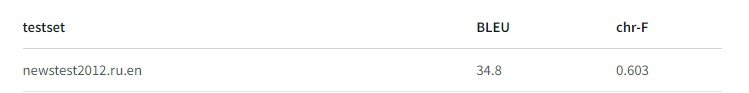

In [ ]:
tokenizer_ru = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model_ru = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

Скачиваем модель с сайта HuggingFace для перевода ответа модели с английского на русский, метрики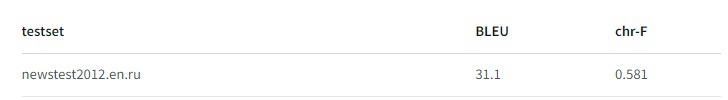

In [ ]:
tokenizer_en = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
model_en = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

Устаналиваем параметр для всех моделей чтобы они использовали видеокарту по умолчанию

In [ ]:
model_ru.to('cuda')
model_en.to('cuda')
model_2.to('cuda')

Создаем описание для записи без звука

In [ ]:
nine = ''
with open("/content/test/test.csv", 'r') as file:
  csvreader = csv.reader(file)
  for row in csvreader:
    if row[0] == '9.mp4':
      nine = row[2]
x = tokenizer_ru(nine, return_tensors="pt")
x = model_ru.generate(**x)
x = tokenizer_ru.batch_decode(x)[0]

a = f"Write a detailed description for a Youtube video named {x[6:-4]} Baikal mile"

inputs = tokenizer_2(a, return_tensors="pt", return_attention_mask=False)
outputs = model_2.generate(**inputs, max_length=200)
text = tokenizer_2.batch_decode(outputs)[0]

text = tokenizer_en(text, return_tensors="pt")
text = model_en.generate(**text)
text = tokenizer_en.batch_decode(text)[0]

text = text[text.index('Описание:')+ len('Описание:'):]
text = text[:text.index('.')]



Записываем полученное описание ко всем остальным

In [30]:
with open('test_out.txt','r+', encoding='utf-8') as w:
    strings = w.readlines()
    for i in range(len(strings)):
        if strings[i].strip()[-1] == '9':
            strings[i] = text + '\n'
    w.seek(0)
    w.writelines(strings)
    w.truncate()

Запись результата в файл .csv

In [ ]:
import pandas as pd
dataset = pd.read_csv("/content/test/sample_submission.csv")

with open("test_out.txt", "r",encoding="utf-8" ) as f:
    for i in range(100):
        x = f.readline()
        dataset['generated_description'][i] = x

dataset.to_csv("model_test_with_generated_sum.csv")
print(dataset.head(10))